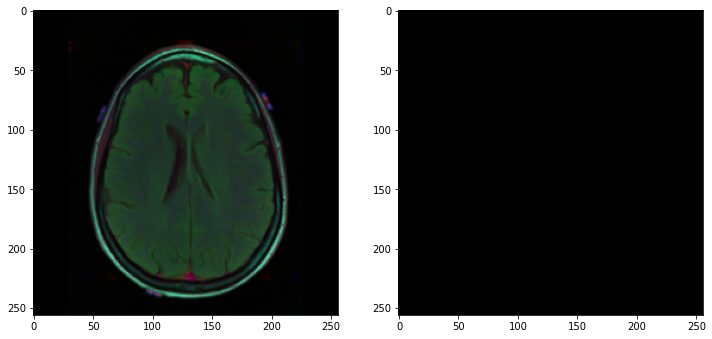

Model: "UNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_38 (Conv2D)             (None, 256, 256, 64  1792        ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_38 (BatchN  (None, 256, 256, 64  256        ['conv2d_38[0][0]']              
 ormalization)                  )                                                              

Epoch 1/10
79/79 [==============================] - 1555s 19s/step - loss: 0.1114 - accuracy: 0.8628 - jacard_coef: 0.0221 - val_loss: 0.2299 - val_accuracy: 0.9286 - val_jacard_coef: 0.0117
Epoch 2/10
79/79 [==============================] - 1466s 19s/step - loss: 0.0443 - accuracy: 0.9840 - jacard_coef: 0.0263 - val_loss: 2.9615 - val_accuracy: 0.4441 - val_jacard_coef: 0.0273
Epoch 3/10
79/79 [==============================] - 1494s 19s/step - loss: 0.0245 - accuracy: 0.9865 - jacard_coef: 0.0324 - val_loss: 0.0892 - val_accuracy: 0.9048 - val_jacard_coef: 0.0491
Epoch 4/10
79/79 [==============================] - 1466s 19s/step - loss: 0.0174 - accuracy: 0.9875 - jacard_coef: 0.0391 - val_loss: 0.0222 - val_accuracy: 0.9795 - val_jacard_coef: 0.0497
Epoch 5/10
79/79 [==============================] - 1357s 17s/step - loss: 0.0139 - accuracy: 0.9886 - jacard_coef: 0.0452 - val_loss: 0.0127 - val_accuracy: 0.9896 - val_jacard_coef: 0.0446
Epoch 6/10
79/79 [===========================

Epoch 1/10
79/79 [==============================] - 1597s 20s/step - loss: 0.1170 - accuracy: 0.8601 - jacard_coef: 0.0208 - val_loss: 0.0575 - val_accuracy: 0.9834 - val_jacard_coef: 0.0480
Epoch 2/10
79/79 [==============================] - 1583s 20s/step - loss: 0.0412 - accuracy: 0.9845 - jacard_coef: 0.0266 - val_loss: 0.0315 - val_accuracy: 0.9834 - val_jacard_coef: 0.0200
Epoch 3/10
79/79 [==============================] - 2290s 29s/step - loss: 0.0251 - accuracy: 0.9859 - jacard_coef: 0.0311 - val_loss: 0.0228 - val_accuracy: 0.9868 - val_jacard_coef: 0.0281
Epoch 4/10
79/79 [==============================] - 1779s 23s/step - loss: 0.0189 - accuracy: 0.9861 - jacard_coef: 0.0356 - val_loss: 0.0154 - val_accuracy: 0.9885 - val_jacard_coef: 0.0424
Epoch 5/10
79/79 [==============================] - 6896s 88s/step - loss: 0.0157 - accuracy: 0.9865 - jacard_coef: 0.0397 - val_loss: 0.0138 - val_accuracy: 0.9886 - val_jacard_coef: 0.0475
Epoch 6/10
 6/79 [=>.........................

KeyboardInterrupt: 

In [5]:
import os
import numpy as np
from matplotlib import pyplot as plt
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from datetime import datetime 
import cv2
from PIL import Image
from keras import backend, optimizers


image_directory = 'Train/Images/'
mask_directory = 'Train/Masks/'


SIZE = 256
image_dataset = []  
mask_dataset = []  

images = os.listdir(image_directory)
for i, image_name in enumerate(images):    #Remember enumerate method adds a counter and returns the enumerate object
    if (image_name.split('.')[1] == 'tif'):
        #print(image_directory+image_name)
        image = cv2.imread(image_directory+image_name, 1)
        image = Image.fromarray(image)
        image = image.resize((SIZE, SIZE))
        image_dataset.append(np.array(image))

#Iterate through all images in Uninfected folder, resize to 64 x 64
#Then save into the same numpy array 'dataset' but with label 1

masks = os.listdir(mask_directory)
for i, image_name in enumerate(masks):
    if (image_name.split('.')[1] == 'tif'):
        image = cv2.imread(mask_directory+image_name, 0)
        image = Image.fromarray(image)
        image = image.resize((SIZE, SIZE))
        mask_dataset.append(np.array(image))


#Normalize images
image_dataset = np.array(image_dataset)/255.
#D not normalize masks, just rescale to 0 to 1.
mask_dataset = np.expand_dims((np.array(mask_dataset)),3) /255.



from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(image_dataset, mask_dataset, test_size = 0.10, random_state = 0)

#Sanity check, view few mages
import random
import numpy as np
image_number = random.randint(0, len(X_train))
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(np.reshape(X_train[image_number], (256, 256, 3)), cmap='gray')
plt.subplot(122)
plt.imshow(np.reshape(y_train[image_number], (256, 256)), cmap='gray')
plt.show()

#######################################
#Parameters for model

IMG_HEIGHT = X_train.shape[1]
IMG_WIDTH  = X_train.shape[2]
IMG_CHANNELS = X_train.shape[3]
num_labels = 1  #Binary
input_shape = (IMG_HEIGHT,IMG_WIDTH,IMG_CHANNELS)
batch_size = 8

#FOCAL LOSS AND DICE METRIC
#Focal loss helps focus more on tough to segment classes.
from focal_loss import BinaryFocalLoss

###############################################################################


#Try various models: Unet, Attention_UNet, and Attention_ResUnet
#Rename original python file from 224_225_226_models.py to models.py
from models import Attention_ResUNet, UNet, Attention_UNet, dice_coef, dice_coef_loss, jacard_coef

'''
UNet
'''
unet_model = UNet(input_shape)
unet_model.compile(optimizer=Adam(lr = 1e-2), loss=BinaryFocalLoss(gamma=2), 
              metrics=['accuracy', jacard_coef])


print(unet_model.summary())

start1 = datetime.now() 
unet_history = unet_model.fit(X_train, y_train, 
                    verbose=1,
                    batch_size = batch_size,
                    validation_data=(X_test, y_test ), 
                    shuffle=False,
                    epochs=10)

stop1 = datetime.now()
#Execution time of the model 
execution_time_Unet = stop1-start1
print("UNet execution time is: ", execution_time_Unet)

unet_model.save('mitochondria_UNet_50epochs_B_focal.hdf5')
#____________________________________________
'''
Attention UNet
'''
att_unet_model = Attention_UNet(input_shape)

att_unet_model.compile(optimizer=Adam(lr = 1e-2), loss=BinaryFocalLoss(gamma=2), 
              metrics=['accuracy', jacard_coef])


print(att_unet_model.summary())
start2 = datetime.now() 
att_unet_history = att_unet_model.fit(X_train, y_train, 
                    verbose=1,
                    batch_size = batch_size,
                    validation_data=(X_test, y_test ), 
                    shuffle=False,
                    epochs=10)
stop2 = datetime.now()
#Execution time of the model 
execution_time_Att_Unet = stop2-start2
print("Attention UNet execution time is: ", execution_time_Att_Unet)

att_unet_model.save('tumor_Attention_UNet_50epochs_B_focal.hdf5')

#___________________________________________
'''
Attention Residual Unet
'''
att_res_unet_model = Attention_ResUNet(input_shape)

att_res_unet_model.compile(optimizer=Adam(lr = 1e-2), loss=BinaryFocalLoss(gamma=2), 
              metrics=['accuracy', jacard_coef])


# att_res_unet_model.compile(optimizer=Adam(lr = 1e-3), loss='binary_crossentropy', 
#               metrics=['accuracy', jacard_coef])

print(att_res_unet_model.summary())


start3 = datetime.now() 
att_res_unet_history = att_res_unet_model.fit(X_train, y_train, 
                    verbose=1,
                    batch_size = batch_size,
                    validation_data=(X_test, y_test ), 
                    shuffle=False,
                    epochs=10)
stop3 = datetime.now()

#Execution time of the model 
execution_time_AttResUnet = stop3-start3
print("Attention ResUnet execution time is: ", execution_time_AttResUnet)

att_res_unet_model.save('mitochondria_AttResUnet_50epochs_B_focal.hdf5')

############################################################################
# convert the history.history dict to a pandas DataFrame and save as csv for
# future plotting
import pandas as pd    
unet_history_df = pd.DataFrame(unet_history.history) 
att_unet_history_df = pd.DataFrame(att_unet_history.history) 
att_res_unet_history_df = pd.DataFrame(att_res_unet_history.history) 

with open('unet_history_df.csv', mode='w') as f:
    unet_history_df.to_csv(f)
    
with open('att_unet_history_df.csv', mode='w') as f:
    att_unet_history_df.to_csv(f)

with open('custom_code_att_res_unet_history_df.csv', mode='w') as f:
    att_res_unet_history_df.to_csv(f)    

#######################################################################
#Check history plots, one model at a time
history = unet_history
history = att_unet_history
history = att_res_unet_history

#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['jacard_coef']
#acc = history.history['accuracy']
val_acc = history.history['val_jacard_coef']
#val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'y', label='Training Jacard')
plt.plot(epochs, val_acc, 'r', label='Validation Jacard')
plt.title('Training and validation Jacard')
plt.xlabel('Epochs')
plt.ylabel('Jacard')
plt.legend()
plt.show()

#######################################################



model = unet_model
model = att_unet_model
model = att_res_unet_model

model_path = "models/mitochondria_UNet_50epochs_B_focal.hdf5"
model_path = "models/mitochondria_Attention_UNet_50epochs_B_focal.hdf5"
model_path = "models/mitochondria_AttResUnet_50epochs_B_focal.hdf5"
#Load one model at a time for testing.
model = tf.keras.models.load_model(model_path, compile=False)


import random
test_img_number = random.randint(0, X_test.shape[0]-1)
test_img = X_test[test_img_number]
ground_truth=y_test[test_img_number]

test_img_input=np.expand_dims(test_img, 0)
prediction = (model.predict(test_img_input)[0,:,:,0] > 0.5).astype(np.uint8)

plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img, cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='gray')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(prediction, cmap='gray')

plt.show()


#IoU for a single image
from tensorflow.keras.metrics import MeanIoU
n_classes = 2
IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(ground_truth[:,:,0], prediction)
print("Mean IoU =", IOU_keras.result().numpy())


#Calculate IoU for all test images and average
 
import pandas as pd

IoU_values = []
for img in range(0, X_test.shape[0]):
    temp_img = X_test[img]
    ground_truth=y_test[img]
    temp_img_input=np.expand_dims(temp_img, 0)
    prediction = (model.predict(temp_img_input)[0,:,:,0] > 0.5).astype(np.uint8)
    
    IoU = MeanIoU(num_classes=n_classes)
    IoU.update_state(ground_truth[:,:,0], prediction)
    IoU = IoU.result().numpy()
    IoU_values.append(IoU)

    print(IoU)
    


df = pd.DataFrame(IoU_values, columns=["IoU"])
df = df[df.IoU != 1.0]    
mean_IoU = df.mean().values
print("Mean IoU is: ", mean_IoU)    
    




In [6]:
stop1 = datetime.now()
#Execution time of the model 
execution_time_Unet = stop1-start1
print("UNet execution time is: ", execution_time_Unet)

unet_model.save('mitochondria_UNet_50epochs_B_focal.hdf5')

UNet execution time is:  8:07:49.403512


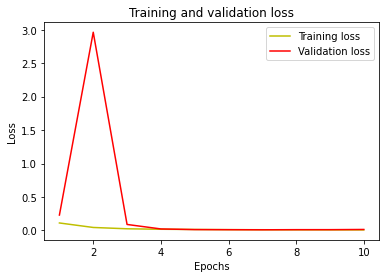

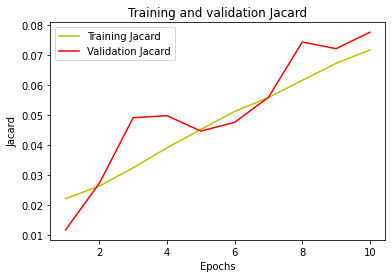

In [7]:
import pandas as pd    
unet_history_df = pd.DataFrame(unet_history.history)
with open('unet_history_df.csv', mode='w') as f:
    unet_history_df.to_csv(f)
history = unet_history
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['jacard_coef']
#acc = history.history['accuracy']
val_acc = history.history['val_jacard_coef']
#val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'y', label='Training Jacard')
plt.plot(epochs, val_acc, 'r', label='Validation Jacard')
plt.title('Training and validation Jacard')
plt.xlabel('Epochs')
plt.ylabel('Jacard')
plt.legend()
plt.show()
model = unet_model






In [9]:

model_path = "mitochondria_UNet_50epochs_B_focal.hdf5"
model = tf.keras.models.load_model(model_path, compile=False)

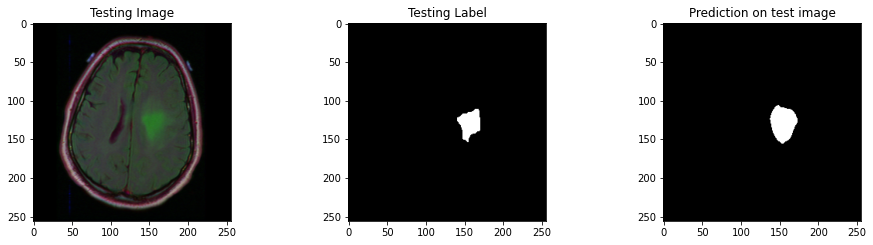

Mean IoU = 0.8124596
1.0
0.7799802
0.49643707
0.49906158
0.7489768
0.7337946
0.5191899
0.77943337
0.46289825
0.46720123
0.5145583
0.42517853
0.92285144
0.49855804
0.47021484
0.8156355
0.8826247
0.4999237
0.8947536
0.6733767
0.9016372
0.4969406
0.6906929
0.6550413
0.49480438
0.9395462
0.6956068
0.61784244
0.797716
0.49599457
0.8318205
1.0
1.0
1.0
0.905167
1.0
1.0
0.6430022
0.5433887
0.6759203
1.0
0.4855194
0.7446867
1.0
1.0
0.75533926
0.78583103
0.9276401
0.78327835
0.8980701
0.49954987
0.637409
0.49578857
0.88516843
1.0
0.4988861
1.0
0.49906158
0.49980927
0.58966523
1.0
0.49995422
1.0
0.84921664
0.8124596
0.69428265
0.8195379
0.8211987
0.49502563
0.82332903
Mean IoU is:  [0.67141188]


In [10]:
import random
test_img_number = random.randint(0, X_test.shape[0]-1)
test_img = X_test[test_img_number]
ground_truth=y_test[test_img_number]

test_img_input=np.expand_dims(test_img, 0)
prediction = (model.predict(test_img_input)[0,:,:,0] > 0.5).astype(np.uint8)

plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img, cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='gray')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(prediction, cmap='gray')

plt.show()


#IoU for a single image
from tensorflow.keras.metrics import MeanIoU
n_classes = 2
IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(ground_truth[:,:,0], prediction)
print("Mean IoU =", IOU_keras.result().numpy())


#Calculate IoU for all test images and average
 
import pandas as pd

IoU_values = []
for img in range(0, X_test.shape[0]):
    temp_img = X_test[img]
    ground_truth=y_test[img]
    temp_img_input=np.expand_dims(temp_img, 0)
    prediction = (model.predict(temp_img_input)[0,:,:,0] > 0.5).astype(np.uint8)
    
    IoU = MeanIoU(num_classes=n_classes)
    IoU.update_state(ground_truth[:,:,0], prediction)
    IoU = IoU.result().numpy()
    IoU_values.append(IoU)

    print(IoU)
    


df = pd.DataFrame(IoU_values, columns=["IoU"])
df = df[df.IoU != 1.0]    
mean_IoU = df.mean().values
print("Mean IoU is: ", mean_IoU)    
    

In [11]:
att_unet_model = Attention_UNet(input_shape)

att_unet_model.compile(optimizer=Adam(lr = 1e-2), loss=BinaryFocalLoss(gamma=2), 
              metrics=['accuracy', jacard_coef])


print(att_unet_model.summary())
start2 = datetime.now() 
att_unet_history = att_unet_model.fit(X_train, y_train, 
                    verbose=1,
                    batch_size = batch_size,
                    validation_data=(X_test, y_test ), 
                    shuffle=False,
                    epochs=10)
stop2 = datetime.now()
#Execution time of the model 
execution_time_Att_Unet = stop2-start2
print("Attention UNet execution time is: ", execution_time_Att_Unet)

att_unet_model.save('tumor_Attention_UNet_50epochs_B_focal.hdf5')

C:\Users\John Joel\anaconda3\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "Attention_UNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_96 (Conv2D)             (None, 256, 256, 64  1792        ['input_5[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_84 (BatchN  (None, 256, 256, 64  256        ['conv2d_96[0][0]']              
 ormalization)                  )                                                    

Epoch 1/10
79/79 [==============================] - 1946s 24s/step - loss: 0.1147 - accuracy: 0.8734 - jacard_coef: 0.0179 - val_loss: 0.2675 - val_accuracy: 0.9834 - val_jacard_coef: 2.0777e-04
Epoch 2/10
79/79 [==============================] - 1504s 19s/step - loss: 0.0449 - accuracy: 0.9821 - jacard_coef: 0.0187 - val_loss: 0.0420 - val_accuracy: 0.9834 - val_jacard_coef: 0.0177
Epoch 3/10
79/79 [==============================] - 1771s 22s/step - loss: 0.0277 - accuracy: 0.9837 - jacard_coef: 0.0260 - val_loss: 0.0684 - val_accuracy: 0.8464 - val_jacard_coef: 0.0238
Epoch 4/10
 7/79 [=>............................] - ETA: 27:16 - loss: 0.0246 - accuracy: 0.9802 - jacard_coef: 0.0316

KeyboardInterrupt: 

In [12]:
stop2 = datetime.now()
#Execution time of the model 
execution_time_Att_Unet = stop2-start2
print("Attention UNet execution time is: ", execution_time_Att_Unet)

att_unet_model.save('tumor_Attention_UNet_50epochs_B_focal.hdf5')

Attention UNet execution time is:  1:31:50.707205


C:\Users\John Joel\anaconda3\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


In [20]:
att_unet_history_df = pd.DataFrame(att_unet_history.history) 
with open('att_unet_history_df.csv', mode='w') as f:
    att_unet_history_df.to_csv(f)
# history = att_unet_history
# loss = history.history['loss']
# val_loss = history.history['val_loss']
# epochs = range(1, len(loss) + 1)
# plt.plot(epochs, loss, 'y', label='Training loss')
# plt.plot(epochs, val_loss, 'r', label='Validation loss')
# plt.title('Training and validation loss')
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.legend()
# plt.show()

# acc = history.history['jacard_coef']
# #acc = history.history['accuracy']
# val_acc = history.history['val_jacard_coef']
# #val_acc = history.history['val_accuracy']

# plt.plot(epochs, acc, 'y', label='Training Jacard')
# plt.plot(epochs, val_acc, 'r', label='Validation Jacard')
# plt.title('Training and validation Jacard')
# plt.xlabel('Epochs')
# plt.ylabel('Jacard')
# plt.legend()
# plt.show()

model = att_unet_model
model_path = "tumor_Attention_UNet_50epochs_B_focal.hdf5"
model = tf.keras.models.load_model(model_path, compile=False)

NameError: name 'att_unet_history' is not defined

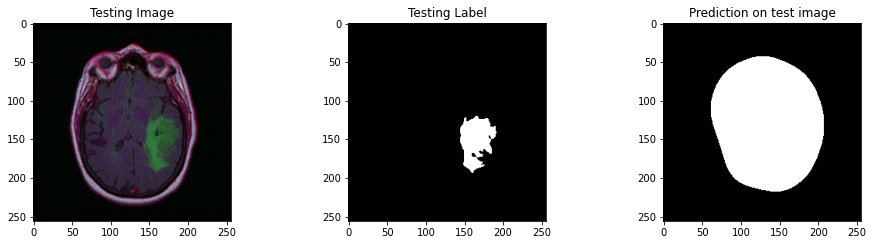

Mean IoU = 0.41285303
0.4381714
0.48978254
0.28347778
0.45413804
0.30291957
0.37446728
0.39648384
0.36205858
0.41983795
0.3021927
0.42098245
0.34136963
0.43997929
0.4166565
0.31866455
0.45270345
0.4706726
0.35460663
0.37907243
0.42795247
0.41285303
0.41407776
0.4538316
0.51962644
0.49480438
0.5090355
0.36732152
0.3855161
0.566895
0.2584076
0.39157584
0.39083862
0.45144653
1.0
0.36507368
0.32209778
1.0
0.48843384
0.4503029
0.44049412
0.30313873
0.3542099
0.44843113
0.42952728
1.0
0.4946823
0.41484606
0.40290007
0.49614716
0.48045498
0.3987742
0.38142765
0.49830627
0.49761897
1.0
0.4296646
0.42101288
0.4897766
0.26421356
0.35059035
1.0
0.42479706
0.28736877
0.42630705
0.34210035
0.46406382
0.5107612
0.5332732
0.46089172
0.5131801
Mean IoU is:  [0.41611212]


In [19]:
import random
test_img_number = random.randint(0, X_test.shape[0]-1)
test_img = X_test[test_img_number]
ground_truth=y_test[test_img_number]

test_img_input=np.expand_dims(test_img, 0)
prediction = (model.predict(test_img_input)[0,:,:,0] > 0.5).astype(np.uint8)

plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img, cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='gray')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(prediction, cmap='gray')

plt.show()


#IoU for a single image
from tensorflow.keras.metrics import MeanIoU
n_classes = 2
IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(ground_truth[:,:,0], prediction)
print("Mean IoU =", IOU_keras.result().numpy())


#Calculate IoU for all test images and average
 
import pandas as pd

IoU_values = []
for img in range(0, X_test.shape[0]):
    temp_img = X_test[img]
    ground_truth=y_test[img]
    temp_img_input=np.expand_dims(temp_img, 0)
    prediction = (model.predict(temp_img_input)[0,:,:,0] > 0.5).astype(np.uint8)
    
    IoU = MeanIoU(num_classes=n_classes)
    IoU.update_state(ground_truth[:,:,0], prediction)
    IoU = IoU.result().numpy()
    IoU_values.append(IoU)

    print(IoU)
    


df = pd.DataFrame(IoU_values, columns=["IoU"])
df = df[df.IoU != 1.0]    
mean_IoU = df.mean().values
print("Mean IoU is: ", mean_IoU)    
    